In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from transformers import AutoTokenizer
from gen_tools import (
    FRED_T5_MODEL_NAME,
    INPUT_TOKEN_LIMIT_FRED_T5,
    TASK_PROMPT,
    MIN_TEXT_TOKENS_FOR_SUMMARIZATION,
    GEMINI_API_KEY,
    GEMINI_MODEL_NAME_PRIMARY
)
import gen_tools
from datasets import load_from_disk
import google.generativeai as genai
import os

DATASET_NAME = 'filtered_fontanka'
OUTPUT_JSONL_FILE = "fontanka_generated_summaries.jsonl"
PROCESSED_INDICES_FILE = "fontanka_processed_indices.txt"
FINAL_HF_DATASET_PATH = "fontanka_gemini"
tokenizer = AutoTokenizer.from_pretrained(FRED_T5_MODEL_NAME)

In [15]:
tokens_in_task_prompt_fred_t5 = len(tokenizer(TASK_PROMPT, add_special_tokens=False)['input_ids'])
NUM_SPECIAL_TOKENS_FOR_FRED_T5_INPUT = 1
MAX_TEXT_TOKENS_FOR_FRED_T5_COMPATIBLE_INPUT = INPUT_TOKEN_LIMIT_FRED_T5 - \
                                               tokens_in_task_prompt_fred_t5 - \
                                               NUM_SPECIAL_TOKENS_FOR_FRED_T5_INPUT

In [16]:
raw_dataset = load_from_disk(DATASET_NAME)
print(f"Loaded '{DATASET_NAME}' split with {len(raw_dataset)} examples.")

Loaded 'filtered_fontanka' split with 17377 examples.


In [17]:
prepared_dataset_for_gemini = gen_tools.preprocess_and_filter_dataset_with_exact_deduplication(
    raw_dataset,
    tokenizer,
    MAX_TEXT_TOKENS_FOR_FRED_T5_COMPATIBLE_INPUT,
    MIN_TEXT_TOKENS_FOR_SUMMARIZATION
)

Starting preprocessing. Initial size: 17377
Targeting max text tokens for processing: 1017


Cleaning, Truncating, and Exact Deduplicating:   0%|          | 0/17377 [00:00<?, ?it/s]

Finished preprocessing. Exact duplicates found and skipped: 37
Filtered dataset size after exact deduplication: 17340


In [18]:
prepared_dataset_for_gemini

Dataset({
    features: ['file', 'processed_text', 'processed_text_tokens'],
    num_rows: 17340
})

<Axes: >

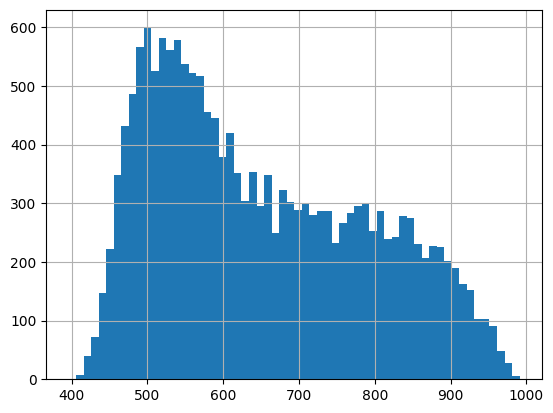

In [19]:
prepared_dataset_for_gemini.to_pandas()['processed_text_tokens'].hist(bins=60)

In [20]:
genai.configure(api_key=GEMINI_API_KEY)
model_gemini = genai.GenerativeModel(GEMINI_MODEL_NAME_PRIMARY)

In [21]:
gen_tools.generate_summaries_resumable_full_stats(prepared_dataset_for_gemini, model_gemini, tokenizer,
                                                  PROCESSED_INDICES_FILE, OUTPUT_JSONL_FILE)

Loaded 17339 already processed indices.
Attempting to process 1 items in this run.


Generating Summaries & Full Stats:   0%|          | 0/1 [00:00<?, ?it/s]


--- Generation Finished for this Run ---
Processed: 0, Total Time: 0.62s, Avg/Item: 0.00s

Source Stats:
  Chars: Avg=3364.00, Min=3364, Max=3364
  Words: Avg=532.00, Min=532, Max=532
  Tokens: Avg=683.00, Min=683, Max=683

All Summary Candidates (0 non-empty):
  No summary data.

Items with no summaries: [3123]
Success distribution:
  0 summaries: 1 items


In [23]:
processed_indices = []
if os.path.exists(PROCESSED_INDICES_FILE): 
    with open(PROCESSED_INDICES_FILE) as f:
        processed_indices = [int(line.strip()) for line in f if line.strip()]
len(processed_indices) == len(set(processed_indices)), len(processed_indices)

(True, 17339)

In [24]:
final_dataset = gen_tools.create_final_huggingface_dataset_from_jsonl(OUTPUT_JSONL_FILE, FINAL_HF_DATASET_PATH)
final_dataset

Created Hugging Face dataset with 17339 examples from JSONL.
Saving Hugging Face dataset to fontanka_gemini...


Saving the dataset (0/1 shards):   0%|          | 0/17339 [00:00<?, ? examples/s]

Hugging Face dataset saved.


Dataset({
    features: ['file', 'text', 'summaries'],
    num_rows: 17339
})